# Teste Técnico Engenheiro de Dados
Nesse notebook está contida a resolução do Teste Técnico presente no seguinte [repositótio](https://github.com/AhirtonLopes/teste_eng_dados3). Todas as respostas estão contidas nesse arquivo. No repositório existem arquivos que permitem a criação de ambientes para uso do notebook tanto usando poetry tanto quanto usando pip.

In [53]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode
from teste_eng_dados.setup import desafio_engenheiro
from PIL import Image
from IPython.display import display 
import json

## Preparação:
Para que as tarefas 1 e 2 pudessem ser feitas e depois avaliadas com um setup mínimo, utilizando somente PySpark, foi criada uma classe com o nome de 'desafio_engenheiro'. Utilizando essa classeiniciamos views temporárias na SparkSession para cada um dos três dataframes , com isso é possível usar sintaxe SQL nos dados contidos nos dataframes como se estivessimos lidando com tabelas em um servidor SQL.

In [54]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("DesafioEngenheiro") \
    .getOrCreate()

In [55]:
spark = desafio_engenheiro(spark=spark).run()

In [56]:
print('cliente :')
spark.sql("SELECT * FROM cliente").show()
print('contrato :')
spark.sql("SELECT * FROM contrato").show()
print('transacao :')
spark.sql("SELECT * FROM transacao").show()

cliente :


+----------+---------+
|cliente_id|     nome|
+----------+---------+
|         1|Cliente A|
|         2|Cliente B|
|         3|Cliente C|
|         4|Cliente D|
+----------+---------+

contrato :
+-----------+-----+----------+----------+
|contrato_id|ativo|percentual|cliente_id|
+-----------+-----+----------+----------+
|          1| true|       2.0|         1|
|          2|false|      1.95|         1|
|          3| true|       1.0|         2|
|          4| true|       3.0|         4|
+-----------+-----+----------+----------+

transacao :
+------------+-----------+-----------+-------------------+
|transacao_id|contrato_id|valor_total|percentual_desconto|
+------------+-----------+-----------+-------------------+
|           1|          1|     3000.0|               6.99|
|           2|          2|     4500.0|               15.0|
|           3|          1|    57989.0|               1.45|
|           4|          4|        1.0|               null|
|           5|          4|       35.0|    

## Tarefa  1 & 2: 
### Tarefa 1:
Escrever uma aplicação para calcular o ganho total da empresa, o qual é obtido a partir da taxa administrativa do serviço de cartão de crédito para seus clientes. Esse ganho é calculado sobre um percentual das transações de cartão de crédito realizadas por eles.
### Tarefa 2:
Calcular o total líquido da empresa. Esse total é calculado da seguinte forma total_liquido = soma(total_bruto – desconto_percentual).

Nessa célula é criada uma tabela que consulta que reúne os dados das três tabelas de fonte em uma única que podemos usar para executar os cálulos necessários e observar alguns detalhes:
* 'Cliente C' não terá participação no ganho total da empresa, pois não possível contrato e por isso não posui transações.
* 'Cliente B' não terá participação no ganho total da empresa, pois por mais que tenha contrato, não possui transações.

In [57]:
print('Componentes Gerais de Cálculo:')
spark.sql(
    """
SELECT
    C.transacao_id,
    D.nome_cliente,
    D.contrato_id,
    D.ativo,
    C.valor_total,
    D.percentual,
    CASE 
        WHEN C.percentual_desconto <> 0 then C.percentual_desconto
        ELSE 0
    END AS percentual_desconto,
    C.valor_total*(D.percentual*0.01) as ganho_total_empresa,
    CASE 
        WHEN C.percentual_desconto <> 0 then C.valor_total*(100-C.percentual_desconto)*0.01
        ELSE C.valor_total
    END AS total_liquido_cliente
FROM transacao C
INNER JOIN (
    SELECT
        B.*,
        A.nome as nome_cliente
    FROM cliente A
    INNER JOIN contrato B ON A.cliente_id = B.cliente_id
    --where ativo = True
) D ON C.contrato_id = D.contrato_id
"""
).show()

Componentes Gerais de Cálculo:


+------------+------------+-----------+-----+-----------+----------+-------------------+-------------------+---------------------+
|transacao_id|nome_cliente|contrato_id|ativo|valor_total|percentual|percentual_desconto|ganho_total_empresa|total_liquido_cliente|
+------------+------------+-----------+-----+-----------+----------+-------------------+-------------------+---------------------+
|           1|   Cliente A|          1| true|     3000.0|       2.0|               6.99|               60.0|               2790.3|
|           2|   Cliente A|          2|false|     4500.0|      1.95|               15.0|              87.75|               3825.0|
|           3|   Cliente A|          1| true|    57989.0|       2.0|               1.45|            1159.78|           57148.1595|
|           4|   Cliente D|          4| true|        1.0|       3.0|                0.0|               0.03|                  1.0|
|           5|   Cliente D|          4| true|       35.0|       3.0|               

Um observação a ser feita é que existem três contratos para 'Cliente A', porêm somente dois tem o status de ativo, como pode ser visto pela coluna 'ativo'. Como não foi específicado se essa diferenciação é necessária os valores foram calculados considerando os dois casos:
* Todos os contratos.
* Somente contratos ativos.
A justificativa para isso é que a depender do intervalo de tempo em que se busca analisar o ganho financeiro, contratos não ativos podem ser relevantes, pois tal contrato poderia estar ativo durante aquele período específico de tempo.

In [58]:
print('Dados Finais:')
print('Considerando todos os contratos:')
spark.sql("""
    SELECT
        nome_cliente,
        SUM(ganho_total_empresa) as ganho_total_empresa,
        SUM(total_liquido_cliente) as total_liquido_cliente
    FROM (SELECT
        nome_cliente,
        SUM(valor_total)*percentual*0.01 as ganho_total_empresa,
        CASE 
            WHEN C.percentual_desconto <> 0 then SUM(C.valor_total)*(100-C.percentual_desconto)*0.01
            ELSE SUM(C.valor_total)
        END AS total_liquido_cliente
    FROM transacao C
    INNER JOIN (
        SELECT
            B.*,
            A.nome as nome_cliente
        FROM cliente A
        INNER JOIN contrato B ON A.cliente_id = B.cliente_id
        --where ativo = True
    ) D ON C.contrato_id = D.contrato_id
    GROUP BY nome_cliente, percentual, percentual_desconto)
GROUP BY nome_cliente
""").show()
print('Considerando somente contratos ativos :')
spark.sql(
    """
    SELECT
        nome_cliente,
        SUM(ganho_total_empresa) as ganho_total_empresa,
        SUM(total_liquido_cliente) as total_liquido_cliente
    FROM (SELECT
        nome_cliente,
        SUM(valor_total)*percentual*0.01 as ganho_total_empresa,
        CASE 
            WHEN C.percentual_desconto <> 0 then SUM(C.valor_total)*(100-C.percentual_desconto)*0.01
            ELSE SUM(C.valor_total)
        END AS total_liquido_cliente
    FROM transacao C
    INNER JOIN (
        SELECT
            B.*,
            A.nome as nome_cliente
        FROM cliente A
        INNER JOIN contrato B ON A.cliente_id = B.cliente_id
        where ativo = True
    ) D ON C.contrato_id = D.contrato_id
    GROUP BY nome_cliente, percentual, percentual_desconto)
GROUP BY nome_cliente
"""
).show()

Dados Finais:
Considerando todos os contratos:


+------------+-------------------+---------------------+
|nome_cliente|ganho_total_empresa|total_liquido_cliente|
+------------+-------------------+---------------------+
|   Cliente A|            1307.53|   63763.459500000004|
|   Cliente D|               1.08|                 36.0|
+------------+-------------------+---------------------+

Considerando somente contratos ativos :


+------------+-------------------+---------------------+
|nome_cliente|ganho_total_empresa|total_liquido_cliente|
+------------+-------------------+---------------------+
|   Cliente A|            1219.78|   59938.459500000004|
|   Cliente D|               1.08|                 36.0|
+------------+-------------------+---------------------+



Os valores contidos no reposítório da proposta do teste para essa questão eram especificamente:
* Cliente A : 1198.77
* Cliente B : 1.08

O valor das respostas encontradas não foi compatível com o que foi disponibilizado. No caso do Cliente B, os dados apontam que ele não contibuí para o resultado, além disso vimos que o valor atribuído a ele é idêntico ao valor calculado para 'Cliente D'. Para o caso do 'Cliente A' não foi possível encontrar evidências que o valor informado seja possível de se obter com essa base de dados, idependente de quais contratos sejam considerados. 

A regra usada para definir a Taxa de Administração foi a seguinte:

$Taxa = valor_{total}\cdot percentual$

In [59]:
df_liquido_todos = spark.sql(
    """
SELECT
    valor_total, percentual_desconto
FROM transacao
"""
)
df_liquido_ativo = spark.sql(
    """
SELECT
    valor_total, percentual_desconto
FROM transacao A
INNER JOIN contrato B ON A.contrato_id = B.contrato_id
WHERE ativo = True
"""
)
total_liquido_todos = (df_liquido_todos
                .withColumn("total_liquido_cliente", col("valor_total") *(100 -  col("percentual_desconto"))*0.01)
                .agg({"total_liquido_cliente": "sum"}).collect()[0][0])
total_liquido_ativo = (df_liquido_ativo
                .withColumn("total_liquido_cliente", col("valor_total") *(100 -  col("percentual_desconto"))*0.01)
                .agg({"total_liquido_cliente": "sum"}).collect()[0][0])
print(f"Total Líquido de todos os contratos: {total_liquido_todos : .2f}")
print(f"Total Líquido de todos os contratos ativos: {total_liquido_ativo : .2f}")

Total Líquido de todos os contratos:  63763.46
Total Líquido de todos os contratos ativos:  59938.46


## Atividade 3:
O terceiro entregável consiste na transformação de dados disponíveis em arquivo Json para o formato de dataframe, algo comum no dia a dia da empresa. Após transformar esse Json em dataframe é possível perceber que a coluna "item_list" está como dicionário. Seu gestor pediu dois pontos de atenção nessa tarefa:

In [60]:
with open('data_files/json/data_nfe.json', 'r') as json_file:
    data_nfe = json.load(json_file)
    json_file.close()

### Expandir a coluna num mesmo dataframe:

In [61]:
df = spark.createDataFrame(data_nfe)
print('DataFrame em seu estado "RAW":')
df.show()
df_expanded = (df.select(
    "CreateDate",
    "EmissionDate",
    "Discount",
    "NFeNumber",
    "NFeID",
    explode("ItemList").alias("Item")
).select(
    "CreateDate",
    "EmissionDate",
    "Discount",
    "NFeNumber",
    "NFeID",
    col("Item.ProductName").alias("ProductName"),
    col("Item.Value").alias("Value"),
    col("Item.Quantity").alias("Quantity")
))
print('DataFrame com coluna "ItemList" expandida')
df_expanded.show()

DataFrame em seu estado "RAW":
+--------------------+--------+-------------------+--------------------+-----+---------+
|          CreateDate|Discount|       EmissionDate|            ItemList|NFeID|NFeNumber|
+--------------------+--------+-------------------+--------------------+-----+---------+
|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|[{Value -> 35.55,...|    1|      501|
|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|[{Value -> 12.25,...|    2|      502|
|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|[{Value -> 9.0, Q...|    3|      503|
+--------------------+--------+-------------------+--------------------+-----+---------+

DataFrame com coluna "ItemList" expandida
+--------------------+-------------------+--------+---------+-----+------------+-----+--------+
|          CreateDate|       EmissionDate|Discount|NFeNumber|NFeID| ProductName|Value|Quantity|
+--------------------+-------------------+--------+---------+-----+------------+-----+--------+
|2021-05-24T20:

### Normalizar os itens dessa coluna de dicionário e dividí-los em dois dataframes separados, seguindo o modelo relacional:
A separação ocorrerá em três tabelas que serão organizadas da seguinte forma:
* NFE:
    * CreateDate
    * EmissionDate
    * Discount
    * NFeNumber
    * NFeID
* Sales:
    * NFeID
    * ProductName
    * Quantity
* Products:
    * ProductName
    * Value
Exemplos de como essas tabelas ficariam podem ser vistos abaixo:

In [62]:
df_NFE = df_expanded.select(
    "CreateDate",
    "EmissionDate",
    "NFeNumber",
    "NFeID",
    "Discount").distinct()
print('NFE:')
df_NFE.show()
df_sales = df_expanded.select(
    "NFeID",
    "ProductName",
    "Quantity")
print('Sales:')
df_sales.show()
df_products = df_expanded.select(
    "ProductName",
    "Value").distinct()
print('Products:')
df_products.show()

NFE:
+--------------------+-------------------+---------+-----+--------+
|          CreateDate|       EmissionDate|NFeNumber|NFeID|Discount|
+--------------------+-------------------+---------+-----+--------+
|2021-05-24T20:21:...|2021-05-24T00:00:00|      501|    1|     0.0|
|2021-05-24T20:21:...|2021-05-24T00:00:00|      502|    2|     0.0|
|2021-05-24T20:21:...|2021-05-24T00:00:00|      503|    3|     0.0|
+--------------------+-------------------+---------+-----+--------+

Sales:
+-----+------------+--------+
|NFeID| ProductName|Quantity|
+-----+------------+--------+
|    1|        Rice|       2|
|    1|       Flour|       5|
|    1|        Bean|       7|
|    2|      Tomate|      10|
|    2|       Pasta|       5|
|    3|        Beer|       6|
|    3|French fries|       2|
|    3|   Ice cream|       1|
+-----+------------+--------+

Products:
+------------+-----+
| ProductName|Value|
+------------+-----+
|        Bean|27.15|
|        Rice|35.55|
|       Flour|11.55|
|      Tomate|

Importante ressaltar que em um ambiente em produção a tabela 'Products' é atualizada separadamente, pois um produto para ser vendido, tem que efetivamente estar cadastardo no sistema da empresa. Essa atualização tende a ser manual.

In [63]:
spark.stop()

## Tarefa 4:
Imagine que o Json das notas fiscais é disponibilizado em uma API. Como você utilizaria as tecnologias da AWS para ingerir, transformar e, eventualmente, carregar esses dados em um Redshift ou oura solução? O quarto entregável consiste na construção de uma arquitetura de ingestão dos dados de nota fiscal do entregável anterior (exemplo de desenho aqui), a qual deve atender aos seguintes pontos:

* Esquemas de fluxo de dados;
* Descrições de funcionamento (se necessário);
* Nomes de tecnologias (serviços, conectores, bibliotecas e módulos).



O processo que pode ser dividido em três partes :
* Ingestão
* Transformação
* Carregamento

A solução que será proposta busca equilibrar custo e adaptabilidade, para isso é necessário definir o passo a passo técnico do projeto, ou seja processos técnicos que serão executados pela nossa pipeline de ingestão de dados. Para isso trabalharemos com algumas suposições sobre a API que usaremos para alimentar o processo:

* Consiste em uma API que feita uma requisição para um período de tempo $d_t$, sendo $d_t$ data e hora final e inicial, retorna todas as notas fiscais emitidas nesse período específicado.
* Essa API é uma 'Black Box', não sabemos sua implementação, só sabemos quais os inputs necessários para alcançar a saída desejada.

O processo técnico pode ser descrito da seguinte forma:
* Ingestão :
    * É feita uma requisição para obtenção dos dados de notas fiscais no formato '.json'.
    * Esse dado será armazenado de forma particionada em um data lake, em uma zona que chamaremos de 'RAW'.
* Transformação :
    * Os dados serão lidos da zona 'RAW' e convertidos do formato de dicionário para tabular.
    * Os dados serão então divididos em dois dataframes representando tabelas descritas na tarefa três. Essas tabelas são as tabela 'NFE' e 'Sales' 
    * Esses dados também serão salvos de forma particionada no date lake. em uma zona que chamaremos de 'STAGED', no formato '.parquet'.
* Carregamento :
    * Os dados serão lidos da área 'STAGED' e inseridos nas tabelas 'NFE' e 'Sales' na Data Warehouse.
    * Esses dados serão salvos em uma zona do data lake que chamaremos de 'REFINED'.

Todas as etapas irão conter logs tanto de sucesso quanto de falha também particionados por data e hora. Serão implementados webhooks para que em caso de falhas no processamento o profisisonal responsável por manutenção seja informado.

A organização de pastas das áreas no date lake será a seguinte:

Datalake

- Datalake
    - RAW
        - NFE_API
            - {datetime}
                - data.json
    - STAGING
        - NFE
            - {datetime}
                - data.parquet
        - Sales
            - {datetime}
                - data.parquet
    - REFINED
        - NFE
            - {datetime}
                - data.parquet
        - Sales
            - {datetime}
                - data.parquet
    - logs
        - NFE_Pipeline
            - Extraction
                - {datetime}
                    - log.txt
            - Treatment
                - {datetime}
                    - log.txt
            - Loading
                - {datetime}
                    - log.txt




Tendo agora uma modelagem mais concreta do processo podemos então definir uma forma de implementação. O caminho mais seguro e que apresenta menor custo seria utilizando Apache Airflow para a orquestração do processo. A forma que o processo será acionado será atráves de um agendamento de execuções da DAG, sendo esse agendamento de 30 em 30 minutos. Isso evita que tenhamos múltiplas execuções successivas de pequenos grupos de dados, oque pode agregar tempo e custo ao processo a depender da configuração da DAG. Dessa forma é possível processarmos grandes agrupamentos de dados em uma execução, ao mesmo tempo que mantemos o sentimento de processamento em tempo real. Para isso os seguintes serviços da Amazon Web Services poderão ser usados :

* Amazon EC2 (Elastic Compute Cloud):
    * Usada para hospedar o Airflow (Scheduler, Web Server e Workers) e o Apache Spark. 
    * Configurar o Airflow em instâncias EC2 oferece flexibilidade para personalizar o ambiente de acordo com suas necessidades.
* Amazon EMR (Elastic MapReduce):
    * Serviço gerenciado que facilita a execução de cargas de trabalho Spark em clusters escaláveis. 
* Amazon RDS (Relational Database Service):
    * Gerencia tarefas de administração, como backup, escalabilidade e manutenção de bancos de dados.
    * Suporte a diferentes tipos de bancos relacionais. 
* Amazon Athena:
    * Serviço de análise interativa que permite consultar dados diretamente no Amazon S3 usando SQL padrão. 
* Amazon S3 (Simple Storage Service):
    * Armazenamento dados brutos ou transformados no S3.
    * O Airflow pode ser configurado para mover dados de/para o S3 como parte dos fluxos de trabalho.
* Amazon Redshift:
    * Data warehouse para consultas analíticas. 
    * O Airflow consegue carregar dados do Data Lake no Redshift periodicamente para análises.
* AWS IAM (Identity and Access Management):
    * Controle de acesso a todos os recursos da AWS de maneira segura.
* Amazon CloudWatch:
    * Monitormaneto de desempenho do Airflow, instâncias EC2, RDS e outros serviços AWS. 
    * Configure alarmes para detectar problemas e notificar a equipe responsável.
* Amazon VPC (Virtual Private Cloud):
    * Usado para controle de tráfego de rede e isolamento de recursos críticos.
* AWS Parameter Store:
    * O AWS Systems Manager Parameter Store pode ser usado para armazenar segredos e configurações, como senhas, e fornece integração fácil com o AWS IAM para controle de acesso.
    * Irá armazenar as credenciais de acesso da API.

O Diagrama do processo pode ser visto abaixo:

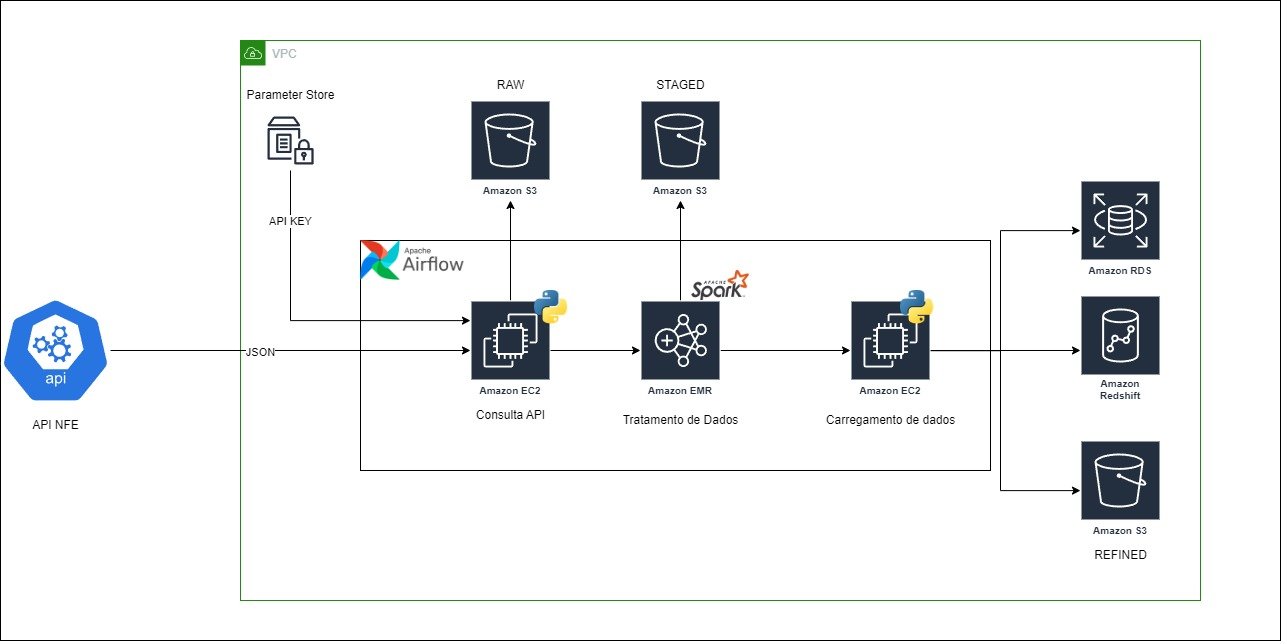

In [64]:
display(Image.open('images/Diagrama Ingestão.jpg', 'r'))

É possível perceber que serviços que foram citados não foram apresentados nesse diagrama sendo eles:
* Amazon Cloud Watch.
* Amazon IAM.
* Amazon Athena.

No caso dos serviços IAM e Cloud Watch eles operam em uma camada mais profunda de infraestrutura  e não seria ótimo representar seu funcionamento em uma pipeline de ingestão de dados. Em relação ao serviço Athena ele pode ser usada internamento no processo do Spark para adquirir os dados da camada área 'RAW' para processamento.
